Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import Sequential

import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2

import pathlib

NOTE: This Notebook contains 2 ML models. Model 1 is for identifying the card color, and model 2 is for identifying the card number.

Model 1 Parameters

In [2]:
color_img_height, color_img_width = 300, 300
color_batch_size = 32

# Load images from directory and split into training and validation sets
color_data_dir = pathlib.Path("../data/colorData")

Model 2 Parameters

In [3]:
num_img_height, num_img_width = 300, 300
num_batch_size = 32

num_data_dir = pathlib.Path("../data/grayNumData")

Collecting Data from the data Folders

In [4]:
color_image_count = len(list(color_data_dir.glob('*/*.jpg')))
print(color_image_count)

num_image_count = len(list(num_data_dir.glob('*/*.jpg')))
print(num_image_count)

1350
1348


Model 1 -> Split the Data into Training and Validation Sets

In [5]:
color_train_ds = tf.keras.utils.image_dataset_from_directory(
  color_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(color_img_height, color_img_width),
  batch_size=color_batch_size)

color_val_ds = tf.keras.utils.image_dataset_from_directory(
  color_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(color_img_height, color_img_width),
  batch_size=color_batch_size)

Found 1350 files belonging to 6 classes.
Using 1080 files for training.
Found 1350 files belonging to 6 classes.
Using 270 files for validation.


Model 2 -> Split the Data into Training and Validation Sets

In [6]:
num_train_ds = tf.keras.utils.image_dataset_from_directory(
  num_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(num_img_height, num_img_width),
  batch_size=num_batch_size)

num_val_ds = tf.keras.utils.image_dataset_from_directory(
  num_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(num_img_height, num_img_width),
  batch_size=num_batch_size)

Found 1348 files belonging to 15 classes.
Using 1079 files for training.
Found 1348 files belonging to 15 classes.
Using 269 files for validation.


Model 1 -> Configure the Dataset for Performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = color_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = color_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Model 2 -> Configure the dataset for Performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = num_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = num_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Model 1 -> Standardizing the Data

In [9]:
color_normalization_layer = layers.Rescaling(1./255)

Model 1 -> Augmenting the Data
(Generates additional training data from the existing examples by augmenting them using random transformations that yield believable-looking images)

In [10]:
color_data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(color_img_height,
                                  color_img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

c:\Users\Adolf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model 2 -> Standardizing the Data

In [11]:
num_normalization_layer = layers.Rescaling(1./255)

Model 2 -> Augmenting the Data

In [12]:
num_data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(num_img_height,
                                  num_img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Creating Model 1 (Color Model)

Note that this Model has three convolustion blocks (tf.keras.layers.Conv2D) and a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). Dropout is included to prevent overfitting of the model.

In [13]:
color_class_names = color_train_ds.class_names
num_color_classes = len(color_class_names)

color_model = Sequential([
  color_data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_color_classes, name="outputs")
])

Creating Model 2 (Number Model) ; Same Format as Model 1

In [14]:
num_class_names = num_train_ds.class_names
num_num_classes = len(num_class_names)

num_model = Sequential([
  num_data_augmentation,
  # layers.Rescaling(1./255),
  # layers.Conv2D(16, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  # # layers.Dropout(0.2),
  # layers.Conv2D(32, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  # # layers.Dropout(0.2),
  # layers.Conv2D(64, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  # # layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_num_classes, name="outputs")
])

Model 1 -> Compiling the Model

In [15]:
color_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model 2 -> Compiling the Model

In [16]:
num_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model 1 -> Training

In [17]:
color_epochs = 7

color_history = color_model.fit(
  color_train_ds,
  validation_data=color_val_ds,
  epochs=color_epochs,
)

Epoch 1/7
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 861ms/step - accuracy: 0.2836 - loss: 3.3176 - val_accuracy: 0.6074 - val_loss: 1.0238
Epoch 2/7
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 890ms/step - accuracy: 0.6755 - loss: 0.7589 - val_accuracy: 0.9519 - val_loss: 0.3089
Epoch 3/7
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 951ms/step - accuracy: 0.9655 - loss: 0.1552 - val_accuracy: 0.9704 - val_loss: 0.0861
Epoch 4/7
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 982ms/step - accuracy: 0.9900 - loss: 0.0306 - val_accuracy: 0.9815 - val_loss: 0.0578
Epoch 5/7
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 999ms/step - accuracy: 0.9927 - loss: 0.0293 - val_accuracy: 0.9889 - val_loss: 0.0300
Epoch 6/7
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 982ms/step - accuracy: 0.9997 - loss: 0.0058 - val_accuracy: 0.9963 - val_loss: 0.0213
Epoch 7/7
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 983ms/step - accuracy: 0.9992 - loss: 0.0048 - val_accuracy: 0.9963 - val_loss: 0.0137


Model 2 -> Training

In [18]:
num_epochs = 50

num_history = num_model.fit(
  num_train_ds,
  validation_data=num_val_ds,
  epochs=num_epochs,
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 596ms/step - accuracy: 0.0590 - loss: 15247.5273 - val_accuracy: 0.0669 - val_loss: 5060.6055
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 603ms/step - accuracy: 0.0780 - loss: 4958.6050 - val_accuracy: 0.0558 - val_loss: 2955.5327
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 603ms/step - accuracy: 0.0988 - loss: 1821.4397 - val_accuracy: 0.0483 - val_loss: 4.0052
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 607ms/step - accuracy: 0.0813 - loss: 3.0561 - val_accuracy: 0.0558 - val_loss: 2.7037
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 596ms/step - accuracy: 0.0804 - loss: 2.7017 - val_accuracy: 0.0558 - val_loss: 2.6994
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 592ms/step - accuracy: 0.0786 - loss: 2.6953 - val_accuracy: 0.0558 - val_loss: 2.6947
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 587ms/step - accuracy: 0.0648 - loss: 2.6903 - val_accuracy: 0.0781 - val_loss: 2.6900
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 575ms/step - accuracy: 0.0827 - loss: 2

Model 1 -> Visualizing Training Results

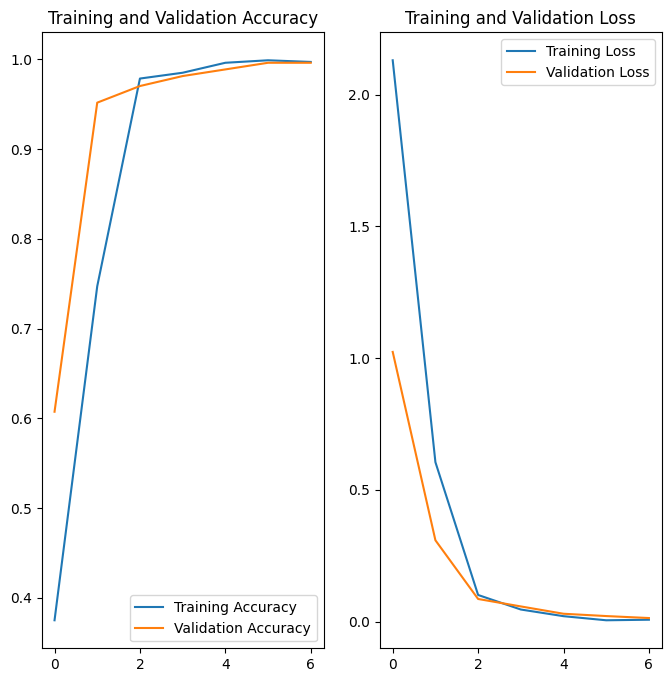

In [19]:
acc = color_history.history['accuracy']
val_acc = color_history.history['val_accuracy']

loss = color_history.history['loss']
val_loss = color_history.history['val_loss']

epochs_range = range(color_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 2 -> Visualizing Training Results

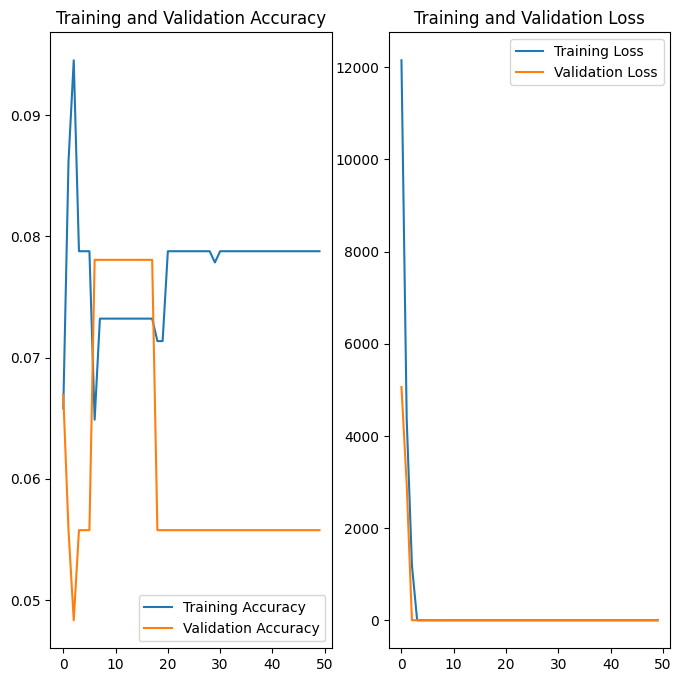

In [20]:
acc = num_history.history['accuracy']
val_acc = num_history.history['val_accuracy']

loss = num_history.history['loss']
val_loss = num_history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Testing on New Data

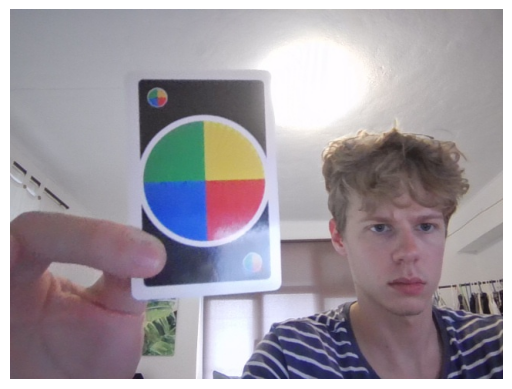

In [21]:
card_path = '../testing_data/cc.jpg'

# Load and display the image
img = plt.imread(card_path)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

Model 1 -> Predicting on New Data

In [22]:
img = tf.keras.utils.load_img(
    card_path, target_size=(color_img_height, color_img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = color_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(color_class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
This image most likely belongs to PickUp4 with a 87.18 percent confidence.


Model 2 -> Predicting on New Data

In [23]:
img = tf.keras.utils.load_img(
    card_path, target_size=(num_img_height, num_img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = num_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(num_class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
This image most likely belongs to 2 with a 7.90 percent confidence.


Starting the GUI so the user can interact with the AI

In [1]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import tensorflow as tf
import numpy as np


# Function to run prediction on uploaded image
def run_prediction_on_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(300, 300))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    color_prediction = color_model.predict(img_array)
    color_score = tf.nn.softmax(color_prediction[0])
    color_predicted_label = color_class_names[np.argmax(color_score)]

    num_prediction = num_model.predict(img_array)
    num_score = tf.nn.softmax(num_prediction[0])
    num_predicted_label = num_class_names[np.argmax(num_score)]
    
    # Display the result
    result_label.config(text=f"Prediction: {color_predicted_label}{num_predicted_label} ({100 * np.max(color_score):.2f}% confidence)")

    # Display the image in GUI
    image = Image.open(image_path)
    image = image.resize((250, 250), Image.ANTIALIAS)
    image = ImageTk.PhotoImage(image)
    image_label.config(image=image)
    image_label.image = image

# Function to handle image upload
def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        run_prediction_on_image(file_path)

# Function to handle video stream
def use_stream():
    cap = cv2.VideoCapture(0)
    
    # Create a new window for edge detection
    edge_window = cv2.namedWindow("Edge Detection")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        height, width, _ = frame.shape
        start_x = width // 4
        start_y = height // 4
        end_x = 3 * width // 4
        end_y = 3 * height // 4

        square_frame = frame[start_y:end_y, start_x:end_x]
        input_image = cv2.resize(square_frame, (300, 300))
        input_image = np.expand_dims(input_image, axis=0)


        # Convert the extracted frame to grayscale
        gray_square_frame = cv2.cvtColor(square_frame, cv2.COLOR_BGR2GRAY)
        gray_input_image = cv2.resize(gray_square_frame, (300, 300))
        # Add a channel dimension to match the input shape expected by the model
        gray_input_image = np.expand_dims(gray_input_image, axis=-1)  # Add channel dimension for grayscale
        # Expand the dimensions to create a batch dimension
        gray_input_image = np.expand_dims(gray_input_image, axis=0)


        color_predictions = color_model.predict(input_image)
        color_score = tf.nn.softmax(color_predictions[0])
        color_predicted_label = color_class_names[np.argmax(color_score)]

        num_predictions = num_model.predict(input_image)
        num_score = tf.nn.softmax(num_predictions[0])
        num_predicted_label = num_class_names[np.argmax(num_score)]

        # Draw bounding box and label
        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
        cv2.putText(frame, f'{color_predicted_label}{num_predicted_label}', (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Show the original video feed with bounding box
        cv2.imshow('Video Feed', frame)
        
        # Apply edge detection to the marked area and display it in a new window
        gray = cv2.cvtColor(square_frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        cv2.imshow("Edge Detection", edges)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Initialize the tkinter window
root = tk.Tk()
root.title("Card Prediction GUI")

# Create and place buttons
upload_button = tk.Button(root, text="Upload Image", command=upload_image)
upload_button.pack(padx=50, pady=10)

stream_button = tk.Button(root, text="Use Stream", command=use_stream)
stream_button.pack(padx=50, pady=10)

# Label to display the prediction result
result_label = tk.Label(root, text="", font=("Arial", 12))
result_label.pack(padx=50, pady=10)

# Label to display the uploaded image
image_label = tk.Label(root)
image_label.pack(padx=50, pady=10)

# Run the tkinter main loop
root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Adolf\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.py", line 1967, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Adolf\AppData\Local\Temp\ipykernel_13452\3566098681.py", line 71, in use_stream
    color_predictions = color_model.predict(input_image)
                        ^^^^^^^^^^^
NameError: name 'color_model' is not defined
